In [2]:
import matplotlib.pyplot as plt



class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Test')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Test')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [3]:
import numpy as np
import random
from PIL import Image

class ImageGenerator:

    @staticmethod
    def create_imperfect_image(image, image_size=(56, 56)):

        new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

        max_offset = image_size[0] - image.shape[0]
        random_x = random.randint(0, max_offset)
        random_y = random.randint(0, max_offset)

        new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
        return new_image

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten


# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test




11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


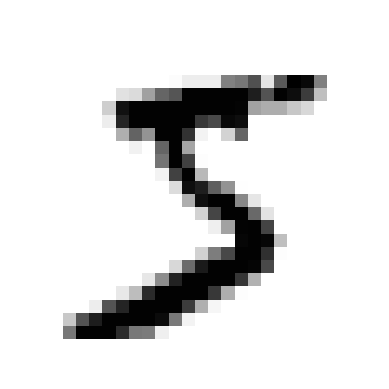

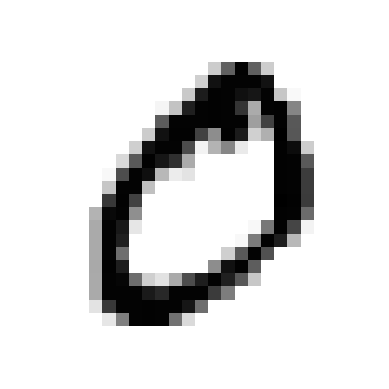

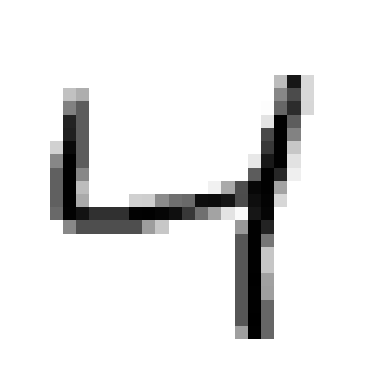

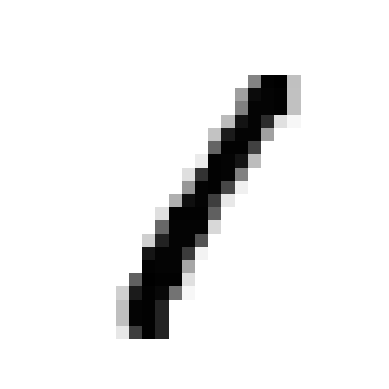

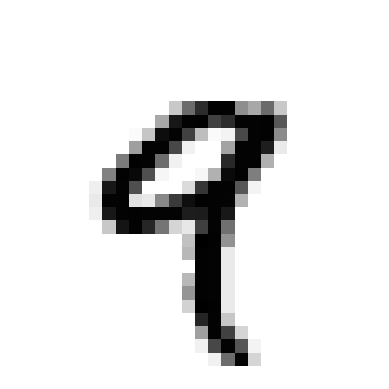

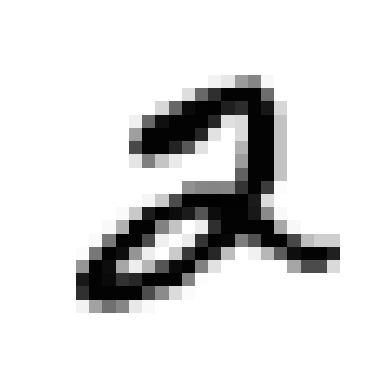

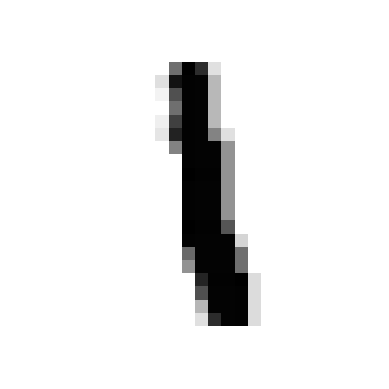

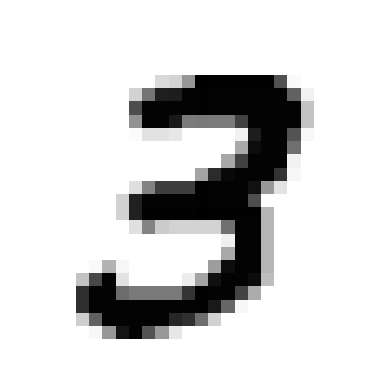

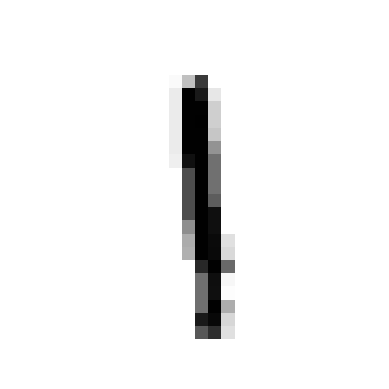

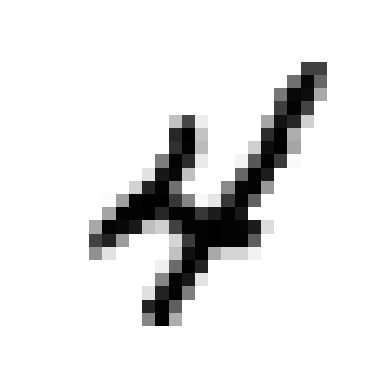

In [4]:
# Apercu dataset
for i in range(10):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis('off')
    plt.show()

In [73]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, Conv2D, MaxPooling2D, Flatten, LSTM, Reshape, BatchNormalization, Bidirectional, GRU, GlobalAveragePooling2D
from sklearn.preprocessing import label_binarize
from tensorflow.keras.optimizers import Adam, AdamW
from PIL import Image


# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test


model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.3),

    Reshape((-1, 64)),
    Bidirectional(GRU(128, activation='tanh')),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])
optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
# Entrainement
historique = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7129 - loss: 0.9398 - val_accuracy: 0.9494 - val_loss: 0.1624
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9684 - loss: 0.1032 - val_accuracy: 0.9837 - val_loss: 0.0543
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9781 - loss: 0.0718 - val_accuracy: 0.9841 - val_loss: 0.0480
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9805 - loss: 0.0642 - val_accuracy: 0.9887 - val_loss: 0.0357
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9837 - loss: 0.0553 - val_accuracy: 0.9879 - val_loss: 0.0403
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9854 - loss: 0.0496 - val_accuracy: 0.9908 - val_loss: 0.0296
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9856 - loss: 0.0451 - val_accuracy: 0.9887 - val_loss: 0.0328
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9866 -

In [ ]:
# Sauvegarde

model.save('model/mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")  # Ou "mon_modele.h5"


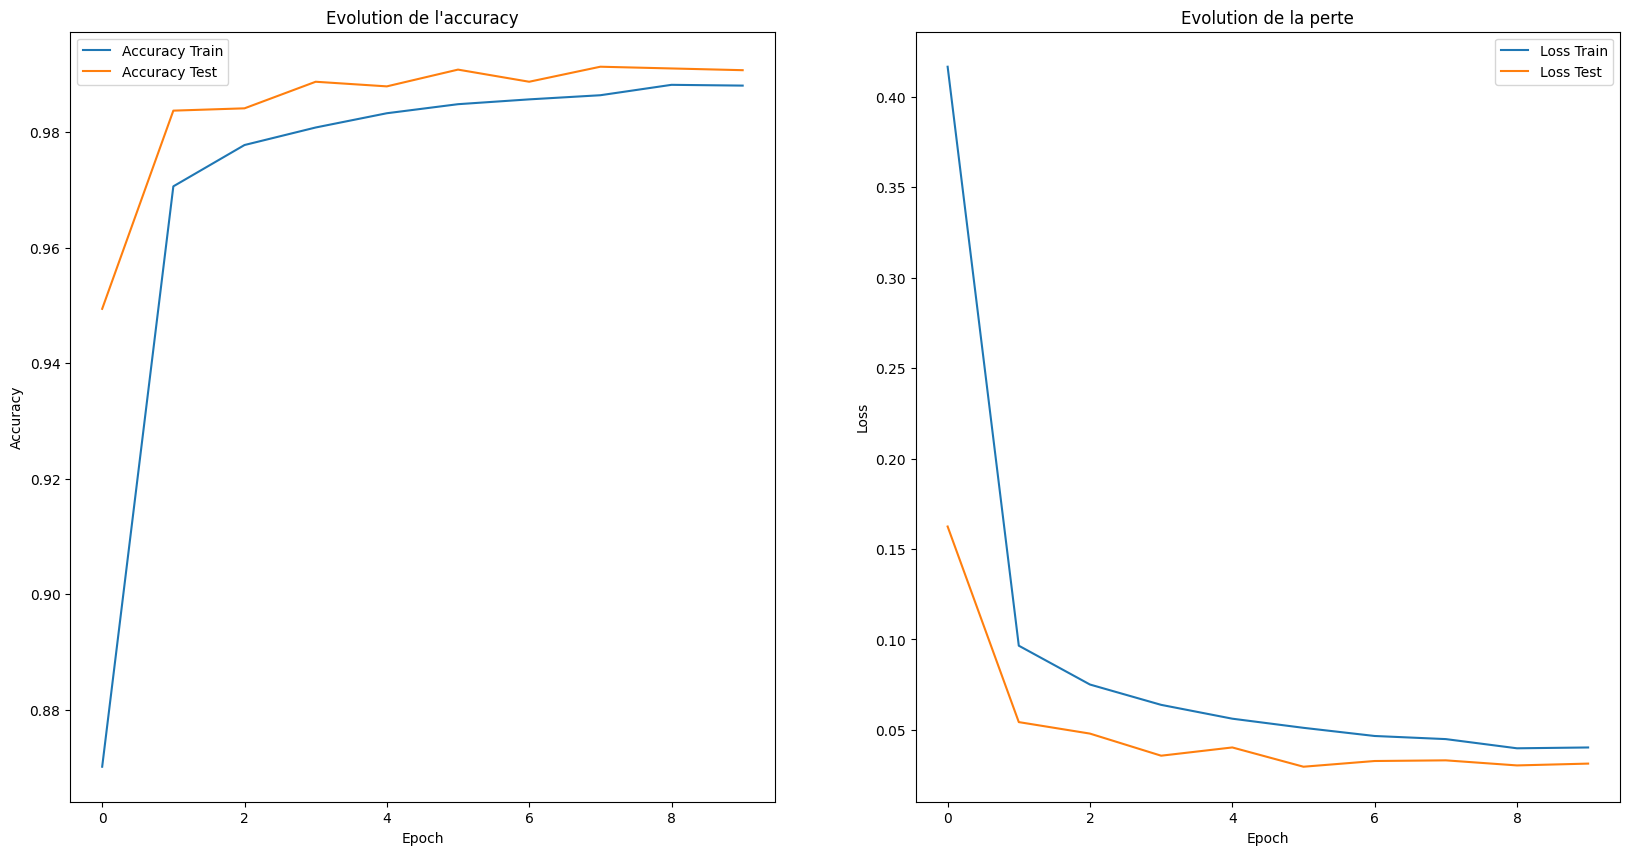

In [76]:
Graphes.accuracy_loss_graphe(historique)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



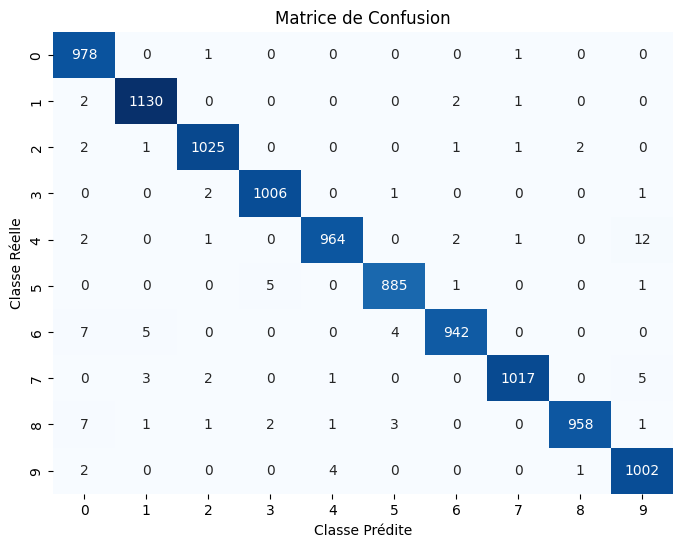

In [77]:
# Stats et matrice de confusion
from sklearn.metrics import classification_report
import seaborn as sns

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


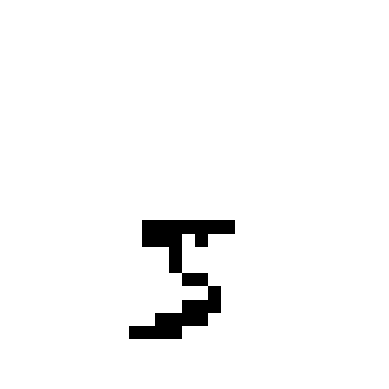

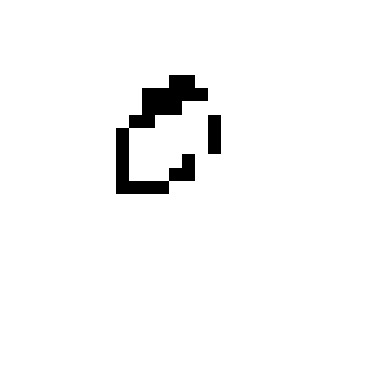

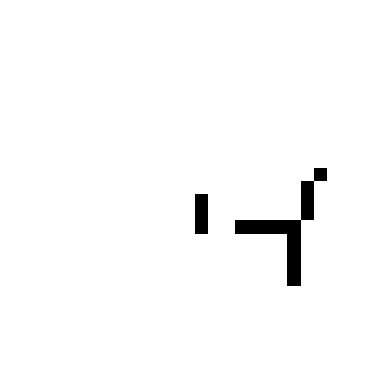

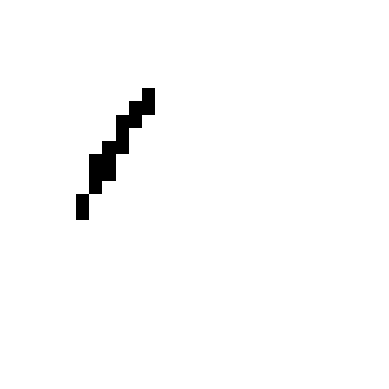

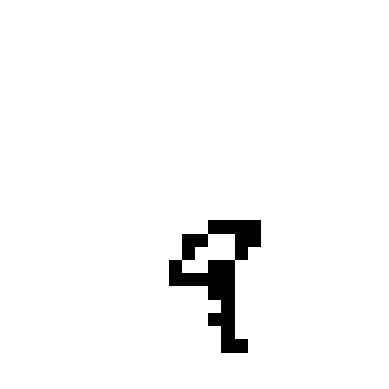

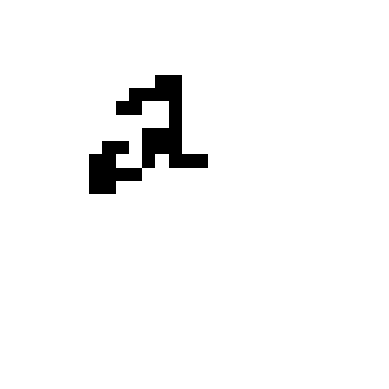

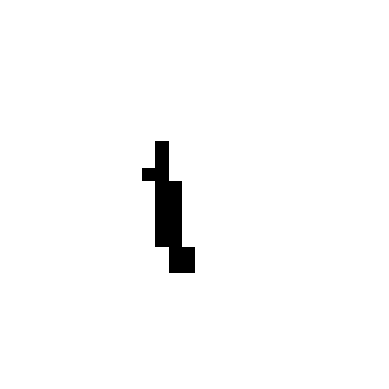

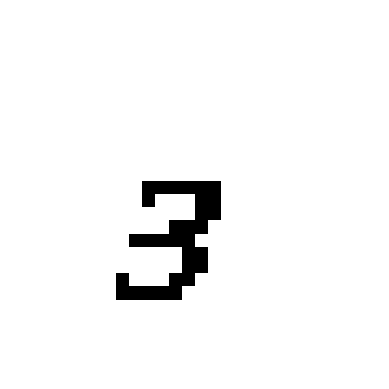

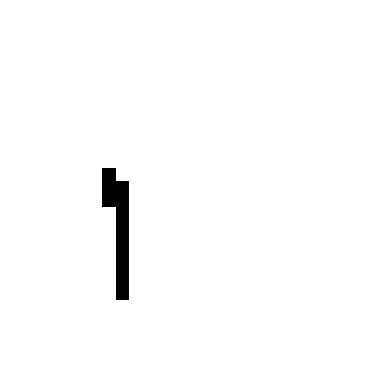

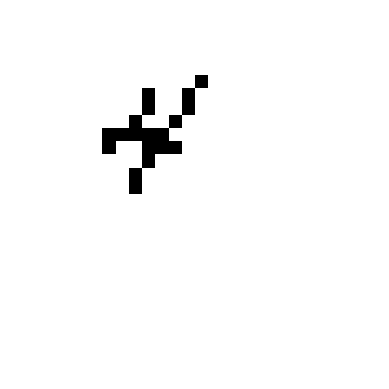

In [65]:
# Création image 56 x 56 avec chiffre positioné aléatoirement
# L'image est ensuite redimensionnée -> 28 x 28

new_images = []
new_images_label = np.array([])

for i in range(10000):
    imperfect_image = ImageGenerator.create_imperfect_image(x_train[i])

    # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
    imperfect_image = tf.expand_dims(imperfect_image, axis=0)
    imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

    imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


    new_images.append(imperfect_image)
    new_images_label = np.append(new_images_label, y_train[i])

    if i < 10:
      plt.figure()
      plt.imshow(imperfect_image, cmap="grey")
      plt.axis('off')
      plt.show()

new_images = np.array(new_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.63      0.59      1001
         1.0       0.87      0.89      0.88      1127
         2.0       0.38      0.84      0.52       991
         3.0       0.57      0.54      0.55      1032
         4.0       0.86      0.17      0.28       980
         5.0       0.83      0.41      0.55       863
         6.0       0.68      0.59      0.63      1014
         7.0       0.96      0.19      0.32      1070
         8.0       0.40      0.59      0.48       944
         9.0       0.42      0.62      0.50       978

    accuracy                           0.55     10000
   macro avg       0.65      0.55      0.53     10000
weighted avg       0.66      0.55      0.54     10000



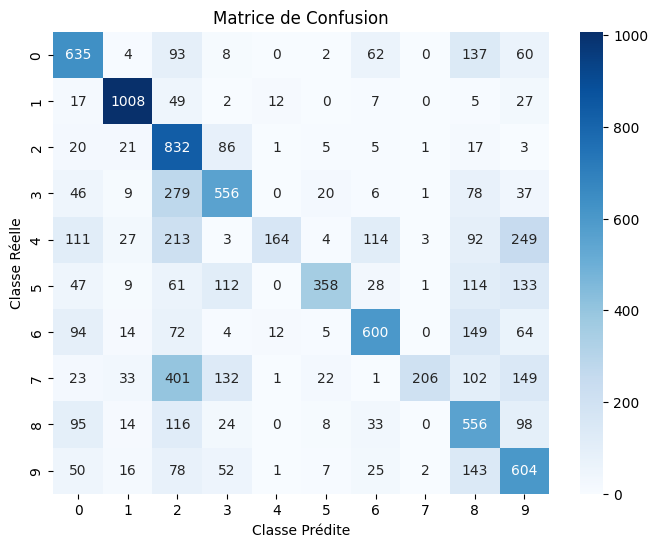

In [78]:
# Résultat sur les nouvelles données
new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()

